## Exercise 1:


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

from pyccel.epyccel import epyccel
from pyccel.decorators import types

ModuleNotFoundError: ignored

In [ ]:
%%file Ex1.py

@types('float[:,:]','float[:,:]','float[:,:]','float[:,:]','int','float','float','float')
def solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy):

    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #$ omp parallel
    for n in range(nt):
        #pragma omp for collapse(2)
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v[i,j]
        #pragma omp for collapse(2)
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] - (un[i,j] *( dt / dx) * (un[i,j] - un[i-1,j])) - (vn[i,j] * (dt / dy) * (un[i,j] - un[i,j-1]))
                v[i,j] = vn[i,j] - (un[i,j] * (dt / dx) * (vn[i,j] - vn[i-1,j])) -( vn[i,j] * (dt / dy) * (vn[i,j] - vn[i,j-1]))
    #$ omp end parallel
        
    return 0
if __name__ == "__main__" :
    
    nx = 90
    ny = 90
    nt = 70
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    sigma = .2
    dt = sigma * dx


    u = np.ones((ny, nx)) 
    v = np.ones((ny, nx))
    un = np.ones((ny, nx))
    vn = np.ones((ny, nx)) 

    solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy)


In [ ]:
!pyccel Ex1.py --language=c --openmp

In [ ]:
cpu_0 = time.process_time()

CPU time       : 0.011417129999999887 



In [ ]:
!export OMP_NUM_THREADS=2; ./Ex1

In [ ]:
cpu_1 = time.process_time()
cpu = cpu_1 - cpu_0
print("CPU time : ", cpu,'\n')

In [ ]:
cpu_0 = time.process_time()

CPU time       : 0.009399354999999332 



In [ ]:
!export OMP_NUM_THREADS=8; ./Ex1

In [ ]:
cpu_1 = time.process_time()
cpu = cpu_1 - cpu_0
print("CPU time       :", cpu,        '\n')

In [ ]:
I = np.arange(1,8,1)

In [ ]:
values = []
for i in I:
    cpu_0 = time.process_time()
    #Execution
    !export OMP_NUM_THREADS=i; ./Exercice1
    #CPU time
    cpu_1 = time.process_time()
    cpu = cpu_1 - cpu_0
    values.append(cpu)


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


Text(0, 0.5, 'time')

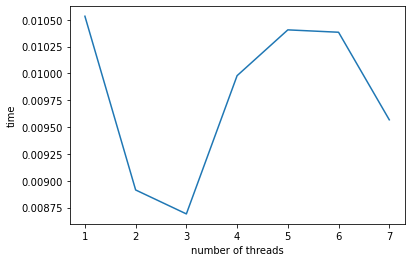

In [ ]:
plt.plot(I,values)
plt.xlabel("number of threads")
plt.ylabel("time")

## Exercise 2:

In [ ]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))
p = np.zeros((ny, nx))
pn = np.ones((ny, nx)) 
b = np.zeros((ny, nx))

## The Navier Stocks Function using Pyccel

In [ ]:
def cavity_flow_pyc(b: 'float[:,:]',nt:'int', u: 'float[:,:]', v: 'float[:,:]', dt: 'float', nx: 'int', ny: 'int', dx: 'float', dy: 'float', p: 'float[:,:]', rho: 'int', nu:'float',un: 'float[:,:]',vn: 'float[:,:]',pn: 'float[:,:]'):
    
    row,col = u.shape
    
    
    for n in range(nt):
        for i in range(row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v [i,j]
                pn[i,j] = p [i,j]
                
        
        b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                    (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
              
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0 
        # Update U   
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                        un[1:-1, 1:-1] * dt / dx *
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        # Update V
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1    
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
        
        

In [ ]:
cavity_flow_pyccel = epyccel(cavity_flow_pyc)

In [ ]:
cpu_0 = time.process_time()
cavity_flow_pyccel(b,nt, u, v, dt, nx, ny, dx, dy, p, rho, nu, un, vn, pn)
cpu_1 = time.process_time()
cpu = cpu_1 - cpu_0
print("CPU time       :", cpu,        '\n')

CPU time       : 0.02543674100000004 



In [ ]:
%%file Exercice1.py

def cavity_flow_pyc(b: 'float[:,:]',nt:'int', u: 'float[:,:]', v: 'float[:,:]', dt: 'float', nx: 'int', ny: 'int', dx: 'float', dy: 'float', p: 'float[:,:]', rho: 'int', nu:'float',un: 'float[:,:]',vn: 'float[:,:]',pn: 'float[:,:]'):
    row,col = u.shape
    #$ omp parallel
    for n in range(nt):
        for i in range(row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v [i,j]
                pn[i,j] = p [i,j]
                
        
        b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                    (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
              
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0 
          
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                        un[1:-1, 1:-1] * dt / dx *
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    #$ omp end parallel

    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1    
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
    
if __name__ == "__main__":
    
    import numpy as np

    nx = 41
    ny = 41
    nt = 500
    nit = 50
    c = 1
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)

    rho = 1
    nu = .1
    dt = .001

    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    un = np.ones((ny, nx))
    vn = np.ones((ny, nx))
    p = np.zeros((ny, nx))
    pn = np.ones((ny, nx)) 
    b = np.zeros((ny, nx))
    
    cavity_flow_pyc(b,nt, u, v, dt, nx, ny, dx, dy, p, rho, nu,un,vn,pn)  

Overwriting Exercice1.py


In [ ]:
!pyccel Ex1.py --language=c --openmp

In [ ]:
cpu_0 = time.process_time()
!export OMP_NUM_THREADS=12; ./Exercice1
cpu_1 = time.process_time()
cpu = cpu_1 - cpu_0
print("CPU time       :", cpu,        '\n')

CPU time       : 0.010888402000002628 



In [ ]:
values = []
for i in I:
    cpu_0 = time.process_time()
    !export OMP_NUM_THREADS=i; ./Exercice1
    cpu_1 = time.process_time()
    cpu = cpu_1 - cpu_0
    values.append(cpu)


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


Text(0, 0.5, 'time')

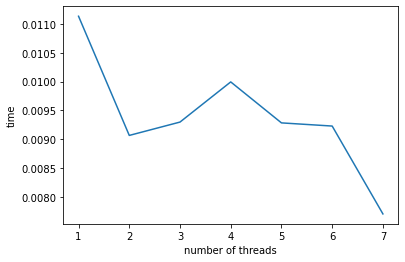

In [ ]:
plt.plot(I,values)
plt.xlabel("number of threads")
plt.ylabel("time")